In [5]:
import sys
from pathlib import Path

# Add nuctool directory to path for imports
nuctool_path = Path.cwd().parent / 'nuctool'
if str(nuctool_path) not in sys.path:
    sys.path.insert(0, str(nuctool_path))

import re
import numpy as np
from scipy.special import erf
from dataclasses import dataclass
import matplotlib.pyplot as plt
from tqdm import tqdm
from snapgene_reader import snapgene_file_to_dict
from numba import jit
from icecream import ic
from Bio import Entrez, SeqIO

from Plotter import Plotter

plot = Plotter()
FIGSIZE = (12, 3)
FILEOUT = rf"figures/nuctool2.jpg"
FILEOUT = None

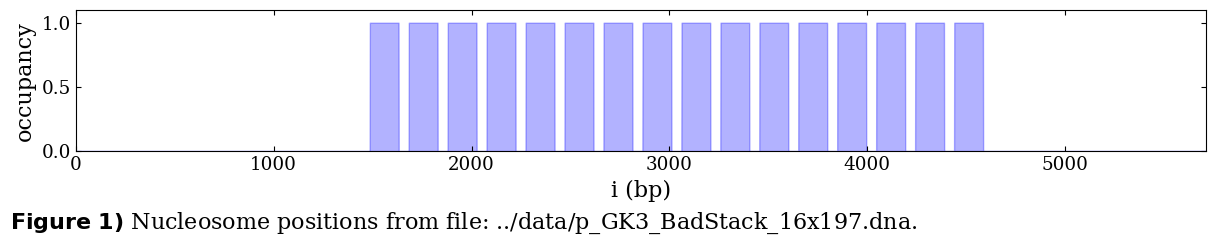

In [6]:
# Some DNA tools for reading or generating sequences with 601 positioning elements

SEQUENCE_601 = "CTGGAGAATCCCGGTGCCGAGGCCGCTCAATTGGTCGTAGCAAGCTCTAGCACCGCTTAAACGCACGTACGCGCTGTCCCCCGCGTTTTAACCGCCAAGGGGATTACTCCCTAGTCTCCAGGCACGTGTCAGATATATACATCCTGT"
FOOTPRINT = len(SEQUENCE_601)


def reverse_complementary(seq: str) -> str:
    complement = str.maketrans("ACGT", "TGCA")
    return seq.translate(complement)[::-1]


def read_dna(filename: str, cut_at=0, show=False) -> tuple[str, list[int]]:
    plasmid_data = snapgene_file_to_dict(filename)
    dyads = []
    for feature in plasmid_data["features"]:
        if "601" in feature["name"].lower():
            dyads.append((feature["start"] + feature["end"]) // 2)
    sequence = plasmid_data["seq"].upper()

    if cut_at > 0:
        sequence = sequence[cut_at:] + sequence[:cut_at]
        dyads = (np.asarray(dyads) - cut_at).tolist()
        dyads = [dyad + len(sequence) if dyad < 0 else dyad for dyad in dyads]

    if show:
        plot.new(fig_size=(12, 2))
        occupancy = np.zeros(len(sequence))
        for dyad in dyads:
            start = max(0, dyad - FOOTPRINT // 2)
            end = min(len(sequence), dyad + FOOTPRINT // 2)
            occupancy[start:end] = 1
        plt.fill_between(range(len(sequence)), occupancy, color="blue", alpha=0.3)
        plt.xlabel("i (bp)")
        plt.ylabel("occupancy")
        plt.xlim(0, len(sequence))
        plt.ylim(0, 1.1)
        plot.caption(f"Nucleosome positions from file: {filename}.", filename=FILEOUT)
    return sequence, dyads


def clean_sequence(dna: str) -> str:
    """Remove non-GATC characters to prevent energy calculation errors."""
    dna = dna.upper().replace("U", "T")
    return re.sub(r"[^GATC]", "", dna)


def create_sequence(contour_length: int, dyads_601: np.ndarray | None = None) -> str:
    """Generate test sequences with known positioning elements for validation."""
    sequence = np.random.choice(list("ACGT"), contour_length)

    if dyads_601 is not None:
        sequence_601 = list(SEQUENCE_601)
        for dyad in dyads_601:
            start_index = max(0, dyad - len(sequence_601) // 2)
            end_index = min(contour_length, dyad + len(sequence_601) // 2)
            length = end_index - start_index
            sequence[start_index : start_index + length] = sequence_601[:length]

    sequence = "".join(sequence)
    return sequence


contour_length = 1000
handle_length = 100
dyads = np.arange(handle_length, contour_length - handle_length, 197)
sequence = create_sequence(contour_length, dyads)

filename = "S_CP115_pUC18 (Amp) 16x167.dna"
filename = "../data/p_GK3_BadStack_16x197.dna"
sequence, dyads = read_dna(filename, cut_at=1700, show=True)

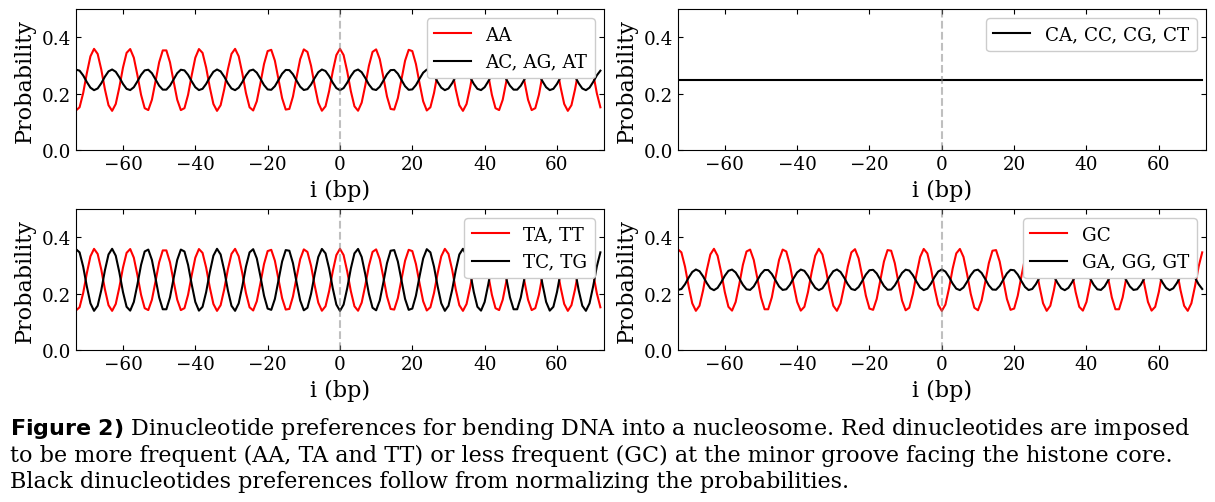

In [7]:
# compute array of position-dependent dinucleotide preferences

FOOTPRINT = 146

_ASCII_TO_IDX = np.full(256, -1, dtype=np.int8)
_ASCII_TO_IDX[ord("A")] = 0
_ASCII_TO_IDX[ord("C")] = 1
_ASCII_TO_IDX[ord("G")] = 2
_ASCII_TO_IDX[ord("T")] = 3


def encode_seq(seq: str) -> np.ndarray:
    """Convert sequence string to numeric indices for vectorized computation."""
    b = np.frombuffer(seq.encode("ascii"), dtype=np.uint8)
    return _ASCII_TO_IDX[b]


def get_weight(w: int, period: float, amplitude: float, show=False) -> np.ndarray:
    """Generate periodic dinucleotide weights to model DNA bendability."""
    x = np.arange(w, dtype=np.int32) - w // 2
    s = amplitude * np.cos(2 * np.pi * x / period)
    weight = np.empty((4, 4, w), dtype=np.float64)
    weight[0, 0] = 0.25 + s
    weight[0, 1] = 0.25 - s / 3
    weight[0, 2] = 0.25 - s / 3
    weight[0, 3] = 0.25 - s / 3
    weight[1, 0] = 0.25
    weight[1, 1] = 0.25
    weight[1, 2] = 0.25
    weight[1, 3] = 0.25
    weight[2, 0] = 0.25 + s / 3
    weight[2, 1] = 0.25 - s
    weight[2, 2] = 0.25 + s / 3
    weight[2, 3] = 0.25 + s / 3
    weight[3, 0] = 0.25 + s
    weight[3, 1] = 0.25 - s
    weight[3, 2] = 0.25 - s
    weight[3, 3] = 0.25 + s

    if show:
        plot.new(fig_size=(12, 4), nrows=2, ncols=2)

        for idx, base1 in enumerate("ACTG"):
            ax = plot.panels[idx]
            label2 = ""
            base2 = "A"
            w1 = weight[*encode_seq(base1 + base2)]
            w2 = -np.ones_like(w1)
            label1 = base1 + base2
            for base2 in "CGT":
                width = weight[*encode_seq(base1 + base2)]
                if np.array_equal(width, w1):
                    label1 += ", " + base1 + base2
                else:
                    w2 = width
                    if label2 is None:
                        label2 = base1 + base2
                    else:
                        if len(label2) > 0:
                            label2 += ", "
                        label2 += base1 + base2
            if len(label1) > len(label2):
                label1, label2 = label2, label1
                w1, w2 = w2, w1

            if w1 is not None:
                ax.plot(x, w1, color="red", label=label1)
            if w2 is not None:
                ax.plot(x, w2, color="black", label=label2)

            ax.axvline(0, color="grey", linestyle="dashed", alpha=0.5)
            ax.legend(loc="upper right", framealpha=1, facecolor="white")
            ax.set_xlabel("i (bp)")
            ax.set_ylabel("Probability")
            ax.set_ylim(0, 0.5)
            ax.set_xlim(-FOOTPRINT // 2, FOOTPRINT // 2)

    return weight


weight = get_weight(FOOTPRINT, period=9.7, amplitude=0.11, show=True)
plot.caption(
    "Dinucleotide preferences for bending DNA into a nucleosome. "
    + "Red dinucleotides are imposed to be more frequent (AA, TA and TT) or less frequent (GC) at the minor groove facing the histone core. "
    + "Black dinucleotides preferences follow from normalizing the probabilities.",
    filename=FILEOUT,
)

findfont: Font family 'Courier New' not found.
findfont: Font family 'Courier New' not found.
findfont: Font family 'Courier New' not found.
findfont: Font family 'Courier New' not found.
findfont: Font family 'Courier New' not found.


findfont: Font family 'Courier New' not found.
findfont: Font family 'Courier New' not found.
findfont: Font family 'Courier New' not found.
findfont: Font family 'Courier New' not found.
findfont: Font family 'Courier New' not found.
findfont: Font family 'Courier New' not found.
findfont: Font family 'Courier New' not found.
findfont: Font family 'Courier New' not found.
findfont: Font family 'Courier New' not found.
findfont: Font family 'Courier New' not found.
findfont: Font family 'Courier New' not found.
findfont: Font family 'Courier New' not found.
findfont: Font family 'Courier New' not found.
findfont: Font family 'Courier New' not found.
findfont: Font family 'Courier New' not found.
findfont: Font family 'Courier New' not found.
findfont: Font family 'Courier New' not found.
findfont: Font family 'Courier New' not found.
findfont: Font family 'Courier New' not found.
findfont: Font family 'Courier New' not found.
findfont: Font family 'Courier New' not found.
findfont: Fon

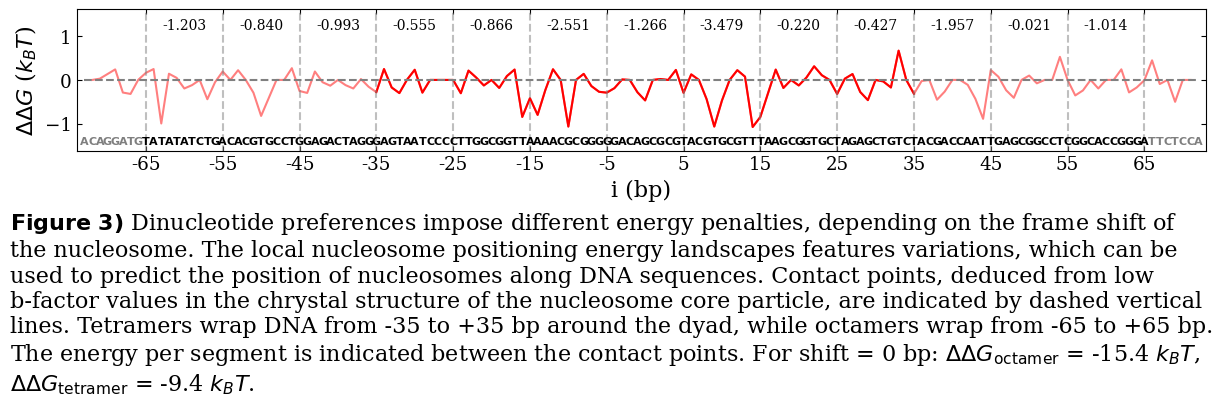

In [ ]:
# Calculate wrapping energy for a nucleosome given its sequence


@dataclass(frozen=True)
class WrappingEnergyResult:
    octamer: float
    tetramer: float
    segments: np.ndarray


def get_unwrapping_segment_positions(left: int = 0, right: int = 0) -> np.ndarray:
    contacts = np.arange(-7, 7).astype(np.int16) * 10 + 5
    dyad = FOOTPRINT // 2
    segments = []
    for i in range(left):
        segments.append((contacts[i] + dyad, contacts[i + 1] + dyad))
    for i in range(right)[::-1]:
        segments.append((contacts[-(i + 2)] + dyad + 1, contacts[-(i + 1)] + dyad + 1))
    return np.asarray(segments)


def calc_wrapping_energy(
    sequence: str, dyad: int, log_weights: np.ndarray, show: str | None = None
) -> WrappingEnergyResult:
    start = -len(log_weights[0, 0]) // 2
    end = start + len(log_weights[0, 0]) + 1
    if dyad + start < 0 or dyad + end - 1 >= len(sequence):
        return WrappingEnergyResult(
            octamer=np.nan, tetramer=np.nan, segments=np.array(np.nan)
        )

    # Extract and encode sequence segment
    seq_segment = sequence[dyad + start : dyad + end - 1]
    idx = encode_seq(seq_segment)

    # sum log-weights for both orientations as nucleosome is symmetric
    n = len(idx) - 1
    indices = np.arange(n)
    forward = log_weights[idx[:-1], idx[1:], indices] + np.log(4.0)
    forward = np.append(forward, np.nan)
    idx_rev = idx[::-1]
    reverse = log_weights[idx_rev[:-1], idx_rev[1:], indices] + np.log(4.0)
    reverse = np.append(reverse, np.nan)[::-1]
    energy = forward + reverse

    # add up energies of segments between contact points
    # make sure that segment boundaries are included for unwrapping from the outside of the octamers
    contacts = np.arange(-7, 7).astype(np.int16) * 10 + 5
    x_positions = np.arange(start, end - 1).astype(np.float64)

    tetramer = np.where((x_positions > -36) & (x_positions < 36))
    octamer = np.where((x_positions > -66) & (x_positions < 66))

    wrapping_energy = np.asarray(
        [
            np.sum(
                energy[(x_positions >= contacts[i]) & (x_positions < contacts[i + 1])]
            )
            for i in range(0, 6)
        ]
        + [np.sum(energy[(x_positions >= contacts[6]) & (x_positions <= contacts[7])])]
        + [
            np.sum(
                energy[(x_positions > contacts[i]) & (x_positions <= contacts[i + 1])]
            )
            for i in range(7, 13)
        ]
    )
    octamer_energy = np.sum(energy[octamer])
    tetramer_energy = np.sum(energy[tetramer])

    if show:
        yrange = np.nanmax(np.abs(energy))

        plot.new(fig_size=(12, 2))
        plt.plot(x_positions, energy, color="red", alpha=0.5)
        plt.plot(x_positions[tetramer], energy[tetramer], color="red")
        plt.hlines(
            0, x_positions[0], x_positions[-1], colors="gray", linestyles="dashed"
        )

        plt.vlines(
            contacts,
            ymin=-10,
            ymax=10,
            colors="grey",
            linestyles="dashed",
            alpha=0.5,
        )
        plt.xticks(contacts, [f"{i}" for i in contacts])
        plt.ylim(-yrange * 1.5, yrange * 1.5)
        plt.xlim(x_positions[0] - 1, x_positions[-1] + 1)

        selection = get_unwrapping_segment_positions(left=3, right=3)
        highlight = [x_positions[i] for seg in selection for i in range(seg[0], seg[1])]
        highlight = []

        for pos, base in zip(x_positions, seq_segment):
            plt.text(
                pos,
                -yrange * 1.2,
                base,
                ha="center",
                va="top",
                fontsize=8,
                family="monospace",
                weight="bold",
                color="red" if pos in highlight else "black",
                alpha=1 if pos in x_positions[octamer] else 0.5,
            )

        for i, e in enumerate(wrapping_energy):
            pos = (contacts[i] + contacts[i + 1]) / 2
            plt.text(pos, yrange * 1.3, f"{e:.3f}", ha="center", va="top")

        plt.xlabel("i (bp)")
        plt.ylabel(r"$\Delta\Delta G$ ($k_B T$)")

        title_text = (
            rf"For shift = {show} bp: "
            rf"$\Delta\Delta G_{{\mathrm{{octamer}}}}$ = {octamer_energy:.1f} $k_BT$, "
            rf"$\Delta\Delta G_{{\mathrm{{tetramer}}}}$ = {tetramer_energy:.1f} $k_BT$."
        )

        plot.caption(
            "Dinucleotide preferences impose different energy penalties, depending on the frame shift of the nucleosome. "
            + "The local nucleosome positioning energy landscapes features variations, which can be used to predict the position of nucleosomes along DNA sequences. "
            + "Contact points, deduced from low b-factor values in the chrystal structure of the nucleosome core particle, are indicated by dashed vertical lines. "
            + "Tetramers wrap DNA from -35 to +35 bp around the dyad, while octamers wrap from -65 to +65 bp. "
            + "The energy per segment is indicated between the contact points. "
            + title_text,
            filename=FILEOUT,
        )
    return WrappingEnergyResult(
        octamer=octamer_energy, tetramer=tetramer_energy, segments=wrapping_energy
    )


log_weights = np.log(weight)


for i in range(-1, 2):
    # for i in [0]:
    if i == 0:
        show = f"{i}"
    else:
        show = None

    calc_wrapping_energy(sequence, dyads[0] + i, log_weights=log_weights, show=show)

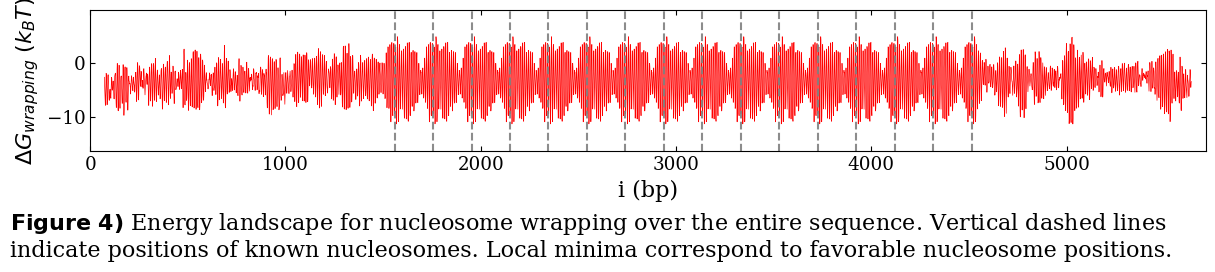

In [9]:
# calculate wrapping energy along the entire sequence of a DNA molecule


def calc_energy_landscape(
    sequence: str, weight: np.ndarray, octamer=True, show=False
) -> np.ndarray:
    if octamer:
        energy = np.asarray(
            [
                calc_wrapping_energy(sequence, i, log_weights=np.log(weight)).octamer
                for i in range(len(sequence))
            ]
        )
    else:
        energy = np.asarray(
            [
                calc_wrapping_energy(sequence, i, log_weights=np.log(weight)).tetramer
                for i in range(len(sequence))
            ]
        )
    if show:
        plot.new(fig_size=(12, 2))
        plt.plot(energy, color="red", linewidth=0.5)

        plt.xlabel("i (bp)")
        plt.xlim(0, len(sequence))
        plt.ylabel(r"$\Delta G_{wrapping}$ $(k_BT)$")
        plt.ylim(np.nanmin(energy) - 5, np.nanmax(energy) + 5)

        plot.caption(
            "Energy landscape for nucleosome wrapping over the entire sequence. "
            + "Vertical dashed lines indicate positions of known nucleosomes. "
            + "Local minima correspond to favorable nucleosome positions.",
            filename=FILEOUT,
        )
    return energy


energy = calc_energy_landscape(sequence, weight, octamer=False, show=True)
plt.vlines(
    dyads,
    ymin=-100,
    ymax=100,
    colors="grey",
    linestyles="dashed",
    alpha=0.9,
)
plt.show()

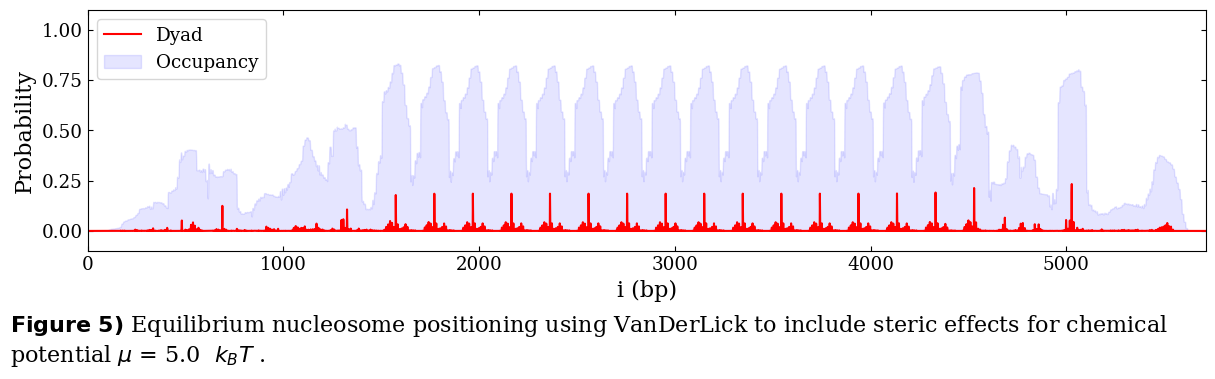

In [10]:
# Distribute nucleosomes along a sequence based on computed wrapping energies.


@dataclass(frozen=True)
class NucPositionResult:
    dyads: np.ndarray
    occupancy: np.ndarray


def compute_vanderlick(
    wrapping_energy: np.ndarray, mu: float, show: bool = False
) -> NucPositionResult:
    """Compute equilibrium dyad probability accounting for steric exclusion between nucleosomes."""

    free_energy = wrapping_energy - mu
    # fill nans with zeros
    free_energy = np.nan_to_num(free_energy, nan=np.nanmax(free_energy))

    n = free_energy.size
    forward = np.zeros(n, dtype=np.float64)
    sum_prev = 0.0
    for i in range(n):
        forward[i] = np.exp(free_energy[i] - sum_prev)
        sum_prev += forward[i]
        if i >= FOOTPRINT:
            sum_prev -= forward[i - FOOTPRINT]
    backward = np.zeros(n, dtype=np.float64)
    r_forward = forward[::-1]
    sum_prod = 0.0
    for i in range(n):
        backward[i] = 1.0 - sum_prod
        sum_prod += r_forward[i] * backward[i]
        if i >= FOOTPRINT:
            sum_prod -= r_forward[i - FOOTPRINT] * backward[i - FOOTPRINT]
    dyads = forward * backward[::-1]
    dyads = np.clip(dyads, 0, np.inf)
    dyads[np.isnan(wrapping_energy)] = 0

    occupancy = np.convolve(dyads, np.ones(FOOTPRINT, dtype=np.float64), mode="same")
    occupancy = np.clip(occupancy, 0, 1)

    if show:
        plot.new(fig_size=FIGSIZE)
        plt.plot(dyads, label="Dyad", color="red")
        plt.fill_between(
            np.arange(len(occupancy)),
            occupancy,
            label="Occupancy",
            color="blue",
            alpha=0.1,
        )
        plt.ylim(-0.10, 1.1)
        plt.xlim(0, len(occupancy))
        plt.xlabel("i (bp)")
        plt.ylabel("Probability")
        plt.legend()
        plot.caption(
            f"Equilibrium nucleosome positioning using VanDerLick to include steric effects for chemical potential $\\mu$ = {chemical_potential}  $k_BT$ .",
            filename=FILEOUT,
        )
    return NucPositionResult(dyads=dyads, occupancy=occupancy)


chemical_potential = 5.0
distribution = compute_vanderlick(energy, chemical_potential, show=True)

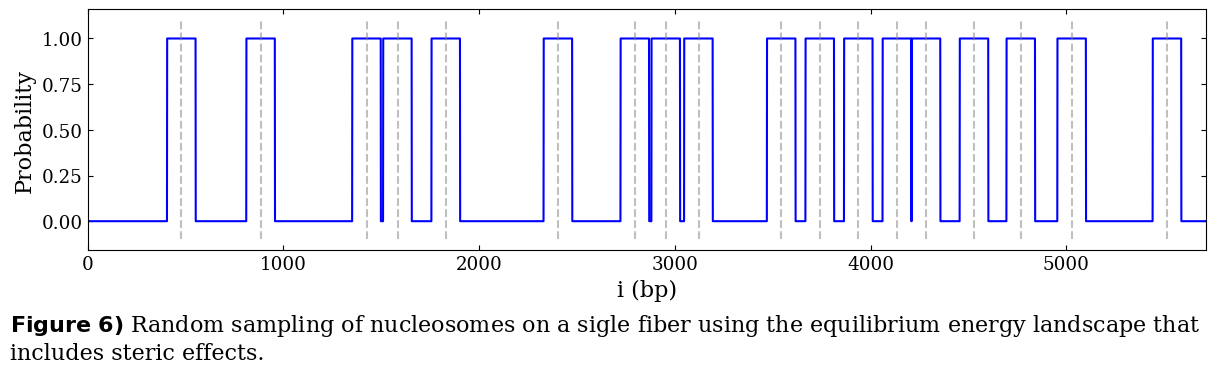

In [11]:
# Compute distirbution by single-molecule sampling


def sample_fiber_configuration(
    dyad_probability: np.ndarray, show: bool = False
) -> NucPositionResult:
    """
    Stochastically sample a single nucleosome arrangement to generate ensemble statistics.
    Edge regions are excluded to prevent boundary artifacts from biasing occupancy.
    """
    p = dyad_probability.copy()
    p[np.isnan(p)] = 0
    occupancy = np.zeros_like(dyad_probability)
    dyads = []

    num_nucleosomes = np.random.poisson(lam=np.sum(p))

    half_footprint = FOOTPRINT // 2
    seq_length = len(dyad_probability)

    for _ in range(int(num_nucleosomes)):
        if p.sum() < 0.5:
            break
        # Sample a dyad position
        dyads.append(np.random.choice(seq_length, p=p / p.sum()))

        nuc_start = dyads[-1] - half_footprint
        nuc_end = nuc_start + FOOTPRINT

        occupancy[nuc_start:nuc_end] = 1
        p[dyads[-1] - FOOTPRINT : dyads[-1] + FOOTPRINT] = 0

    dyads = np.sort(np.asarray(dyads))

    if show:
        plot.new(fig_size=FIGSIZE)
        plt.plot(occupancy, label="Occupancy", color="blue")
        plt.xlim(0, len(occupancy))
        plt.xlabel("i (bp)")
        plt.ylabel("Probability")
        plt.vlines(dyads, -0.1, 1.1, color="grey", linestyle="dashed", alpha=0.5)

    return NucPositionResult(dyads=dyads, occupancy=occupancy)


sample_fiber_configuration(distribution.dyads, show=True)

plot.caption(
    "Random sampling of nucleosomes on a sigle fiber using the equilibrium energy landscape that includes steric effects.",
    filename=FILEOUT,
)

100%|██████████| 1000/1000 [00:00<00:00, 1041.47it/s]


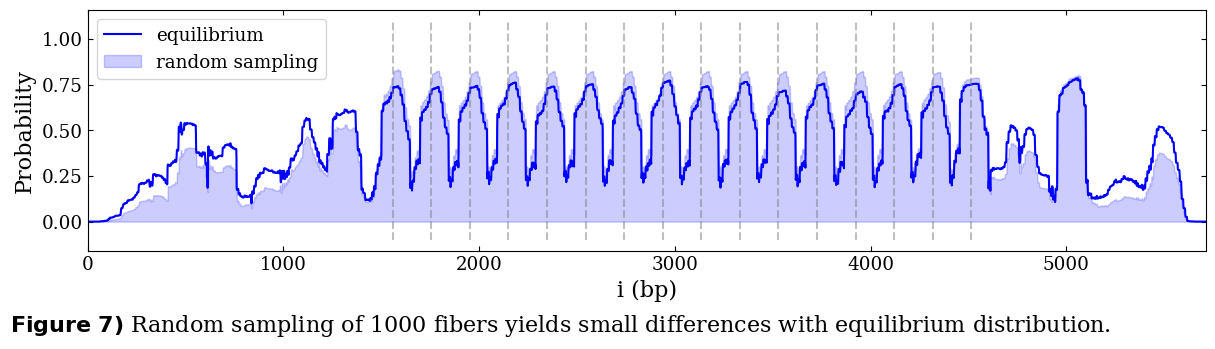

In [12]:
# Check that average over many samples recapitulates equilibrium distributions.
# However, for high densities, occupancy is underestimated due to steric exclusion.

n = 1000
mean_occupancy = np.zeros_like(distribution.occupancy)
for _ in tqdm(range(n)):
    mean_occupancy += sample_fiber_configuration(
        distribution.dyads, show=False
    ).occupancy
mean_occupancy /= n

plot.new(fig_size=FIGSIZE)
plt.plot(mean_occupancy, color="blue", label="equilibrium")
plt.fill_between(
    range(len(distribution.occupancy)),
    distribution.occupancy,
    label="random sampling",
    color="blue",
    alpha=0.2,
)
plt.xlim(0, len(sequence))
plt.xlabel("i (bp)")
plt.ylabel("Probability")
plt.vlines(dyads, -0.1, 1.1, color="grey", linestyle="dashed", alpha=0.5)
plt.legend()


plot.caption(
    f"Random sampling of {n} fibers yields small differences with equilibrium distribution.", filename=FILEOUT
)

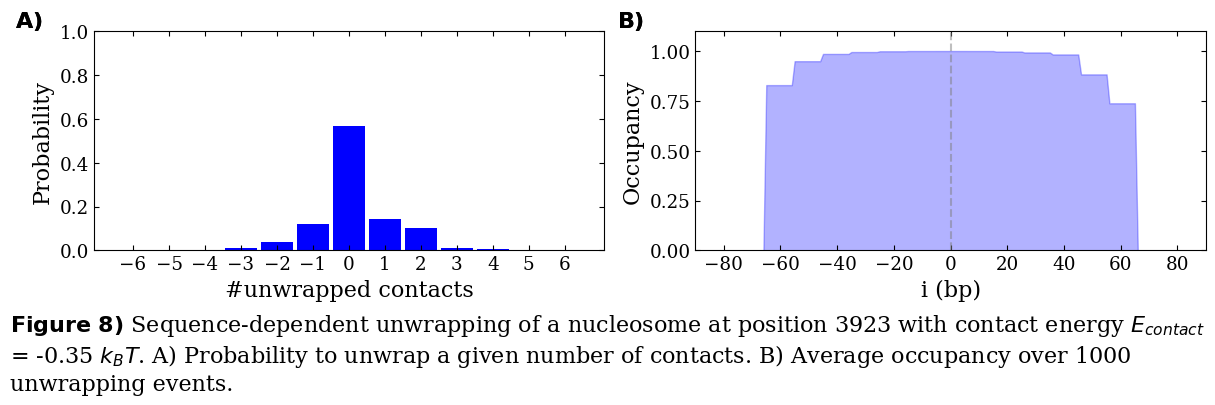

In [13]:
def sample_unwrapping(
    sequence: str, dyad: int, e_contact: float = 1.0, show: bool = False
) -> tuple[np.ndarray, np.ndarray]:
    e_seg = calc_wrapping_energy(sequence, dyad, log_weights=np.log(weight)).segments

    states = np.arange(13).astype(int) - 6
    e = np.concatenate(
        (
            np.cumsum(-e_seg[:6] - e_contact)[::-1],
            [0],
            np.cumsum(-e_seg[::-1][:6] - e_contact),
        )
    )

    p = np.exp(-e)
    p /= p.sum()

    state = np.random.choice(states, p=p)

    wrapped = np.asarray([-65, 65])
    if state < 0:
        wrapped[0] -= state * 10
    else:
        wrapped[1] -= state * 10

    x = np.arange(-75, 75)
    occupancy = np.sum(
        [
            p[i]
            * (
                (x >= (-65 - state * 10 if state < 0 else -65))
                & (x <= (65 if state < 0 else 65 - state * 10))
            )
            for i, state in enumerate(states)
        ],
        axis=0,
    )

    if show:
        plot.new(fig_size=FIGSIZE, ncols=2)
        plot.panels[0].bar(states, p, color="blue", width=0.9)
        plot.panels[0].set_xticks(states)
        plot.panels[0].set_ylim(0, 1)
        plot.panels[0].set_xlabel("#unwrapped contacts")
        plot.panels[0].set_ylabel("Probability")
        plot.panels[0].set_title(f"Probability to unwrap a given number of contacts.")

        plot.panels[1].fill_between(x, occupancy, color="blue", alpha=0.3)
        plot.panels[1].axvline(x=0, linestyle="--", color="grey", alpha=0.5)
        plot.panels[1].set_xlim(-90, 90)
        plot.panels[1].set_ylim(0, 1.1)
        plot.panels[1].set_xlabel("i (bp)")
        plot.panels[1].set_ylabel("Occupancy")
        plot.panels[1].set_title(f"Average occupancy over 1000 unwrapping events.")
        plot.caption(
            f"Sequence-dependent unwrapping of a nucleosome at position {dyad} with contact energy $E_{{contact}}$ = {e_contact} $k_BT$."
        , filename=FILEOUT)
        plt.show()
    return x, occupancy


x, o = sample_unwrapping(sequence, dyads[0], e_contact=-0.35, show=True)

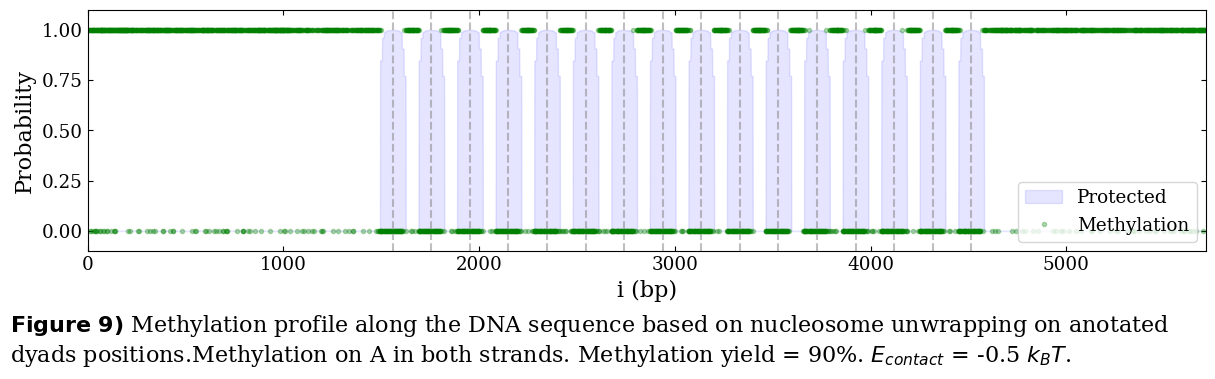

In [14]:
@dataclass(frozen=True)
class MethylationResult:
    protected: np.ndarray
    methylated: np.ndarray


def calc_methylation(
    sequence: str,
    dyads: np.ndarray | list[int],
    e_contact: float = -1.0,
    motifs: list[str] = ["A"],
    strand: str = "both",
    efficiency: float = 0.85,
    show: bool | str = False,
) -> MethylationResult:
    """Calculate methylation pattern based on nucleosome positions and unwrapping."""

    methylation_targets = np.zeros(len(sequence), dtype=int)
    for motif in motifs:
        offset = 1 if motif == "GC" else 0
        if strand in ["both", "forward", "+"]:
            for match in re.finditer(motif, sequence):
                methylation_targets[match.start() + offset] = 1
        if strand in ["both", "reverse", "-"]:
            rev_motif = motif[::-1].translate(str.maketrans("ACGT", "TGCA"))
            for match in re.finditer(rev_motif, sequence):
                methylation_targets[match.start() + offset] = 1

    protected = np.zeros(len(sequence)).astype(np.float64)
    for dyad in dyads:
        x, occupancy = sample_unwrapping(
            sequence, dyad, e_contact=e_contact, show=False
        )
        protected[x + dyad] += occupancy

    protected = np.clip(protected, 0, 1)
    p_methylated = (1 - protected) * methylation_targets * efficiency
    methylated = np.random.binomial(1, p_methylated).astype(float)

    # remove non-target bases from methylation array
    methylated[methylation_targets == 0] = np.nan

    if show:
        plot.new(fig_size=FIGSIZE)
        plt.fill_between(
            range(len(sequence)),
            protected,
            color="blue",
            alpha=0.1,
            label="Protected",
        )
        plt.vlines(
            dyads, ymin=-0.1, ymax=1.1, colors="grey", linestyles="dashed", alpha=0.5
        )
        plt.plot(methylated, ".", color="green", alpha=0.3, label="Methylation")
        plt.ylim(-0.1, 1.1)
        plt.xlim(0, len(sequence))
        plt.legend(loc="lower right")
        plt.xlabel("i (bp)")
        plt.ylabel("Probability")
        if isinstance(show, str):
            show += f"Methylation on {', '.join(motifs)} in {strand} strands. "
            show += f"Methylation yield = {efficiency:.0%}. "
            show += f"$E_{{contact}}$ = {e_contact} $k_BT$. "
            plot.caption(show, filename=FILEOUT)

    # return float array (with NaN for non-targets) to avoid invalid cast warnings
    return MethylationResult(protected, methylated)


calc_methylation(
    sequence,
    dyads,
    e_contact=-0.5,
    motifs=["A"],
    strand="both",
    efficiency=0.9,
    show="Methylation profile along the DNA sequence based on nucleosome unwrapping on anotated dyads positions.",
);

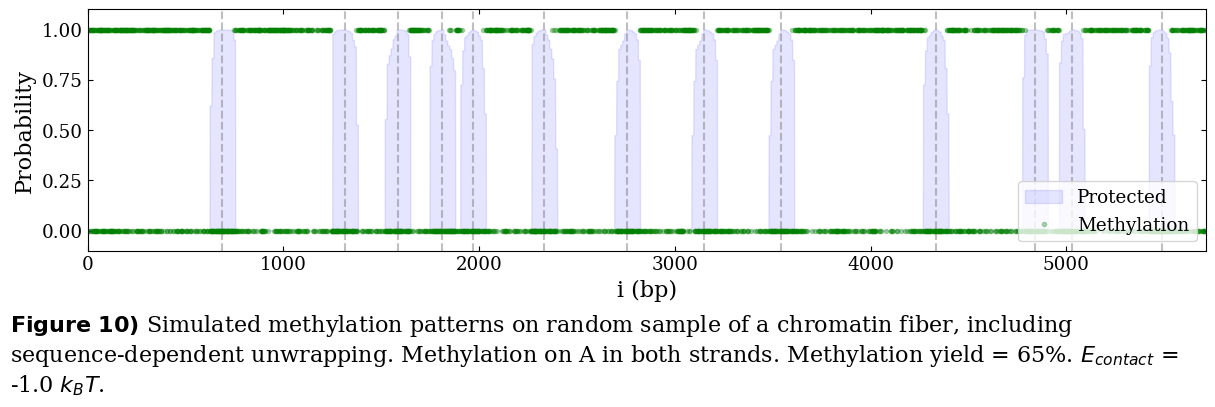

In [15]:
caption = f"Simulated methylation patterns on random sample of a chromatin fiber, including sequence-dependent unwrapping. "

fiber = sample_fiber_configuration(distribution.dyads, show=False)
modified_fiber = calc_methylation(
    sequence,
    fiber.dyads,
    e_contact=-1.0,
    efficiency=0.65,
    motifs=["A"],
    strand="both",
    show=caption,
)

In [16]:
def encode_methylation(sequence: str, methylated: np.ndarray) -> str:
    """Encode methylation status by capitalizing methylated bases.

    Accepts methylated as float array with 1.0 for methylated, 0.0 for unmethylated,
    and np.nan for non-target bases. Treat values >= 0.5 as methylated.
    """
    encoded_sequence = np.array(list(sequence.lower()))
    # build boolean mask: methylated==1 or methylated >= 0.5; handle NaNs
    methylated_mask = np.isfinite(methylated) & (methylated >= 0.5)
    if methylated_mask.any():
        encoded_sequence[methylated_mask] = np.char.upper(
            encoded_sequence[methylated_mask].astype(str)
        )
    return "".join(encoded_sequence)


encoded_sequence = encode_methylation(sequence, modified_fiber.methylated)
print(encoded_sequence[:2000])

agAagAcTcgctAgAAcAtggAagAcAAtTacgTtATcaaaAaggAtcttcAccTAgaTccTTtTAAaTTAAaAAtgaagTTttaAATcAagcccAaTctgAATAaTgttAcAaccAAttaaccaattcTgAttAgAAaAActcATcgAgcaTcaaATgaAacTgcaATTTATtcATAtcAggATTAtcAatAccAtATTTtTgaAaAAgccgTTTctgTAATgAAggagAAaAcTcAccgAggcAgtTccataggaTggcAAgaTcctggtaTcggTctgcgatTccgAcTcgTccaAcATcAATAcaAccTatTaaTTTccccTcgtcAAAAATaAggTTATcaagtgAgaAaTcaccaTgagTgAcgActgaAtccggTgAgAATggcAaAAgTTTATgcAtTtcTTTccAgAcTtgtTcAAcAggccAgccATTacgctcgTcATcAAaAtcActcgcatcAAccAAAccgTTattcaTtcgtgATTgcgccTgAgcgagacgAaaTAcgcgaTcgctgTTAaAaggAcAATTAcAAacAggAATcgaaTgcaAccggcgcAggaAcActgccAgcgcATcAAcaATatTtTcAccTgAATcAggAtatTcTTcTAATacctggaatgctgtttttccggggatcgcagtggtgagtaaccatgcatcatcaggagtacggataaaatgcttgatggtcggaagaggcataaattccgtcagccagtttagtctgaccatcTcatctgTaAcaTcattggcAacgctaccTTTgccATgTttcAgAaAcAActcTggcgcatcgggcTTcccaTacaagcgATAgATtgTcgcAccTgaTtgcccgAcATTAtcgcgAgcccAtTTATAcccATATAAAtcagcatccAtgttggAAtTTaaTcgcggccTcgAcgTtTcccgTTgAATATggcTcATAAcAcccctTgTAtTAcTgtTTaTgTAagcagAcagTTTtAtTgTtcATgaTgATATA

In [17]:
def fetch_coords(gene_name: str, organism: str = "saccharomyces cerevisiae") -> dict:
    Entrez.email = "your.email@example.com"
    q = f"{gene_name}[Gene Name] AND {organism}[Organism]"
    res = Entrez.read(Entrez.esearch(db="gene", term=q))
    if not res.get("IdList"):
        raise ValueError(f"Gene {gene_name} not found for {organism}")
    gid = res["IdList"][0]
    doc = Entrez.read(Entrez.esummary(db="gene", id=gid))["DocumentSummarySet"][
        "DocumentSummary"
    ][0]
    gi = doc.get("GenomicInfo", [{}])[0]
    raw_start = int(gi.get("ChrStart", 0))
    raw_stop = int(gi.get("ChrStop", 0))
    start = min(raw_start, raw_stop) + 1
    end = max(raw_start, raw_stop) + 1
    # parse/normalize strand to int
    s = gi.get("Strand")
    try:
        strand = int(s) if s is not None else (-1 if raw_start > raw_stop else 1)
    except Exception:
        ss = str(s).lower() if s is not None else ""
        strand = (
            -1
            if ss.startswith("m") or ss.startswith("-")
            else (
                1
                if ss.startswith("p") or ss.startswith("+")
                else (-1 if raw_start > raw_stop else 1)
            )
        )
    return {
        "gene_name": gene_name,
        "gene_id": gid,
        "chrom_acc": gi.get("ChrAccVer"),
        "start": start,
        "end": end,
        "strand": int(strand),
        "chrom_name": doc.get("Chromosome", "Unknown"),
        "raw_start": raw_start,
        "raw_stop": raw_stop,
    }


def fetch_sequence(
    coords: dict, margin_upstream: int = 0, margin_downstream: int = 0
) -> tuple[np.ndarray, str]:
    Entrez.email = "your.email@example.com"
    chrom = coords.get("chrom_acc")
    start = int(coords["start"])
    end = int(coords["end"])
    strand = int(coords.get("strand", 1))
    full = SeqIO.read(
        Entrez.efetch(
            db="nuccore", id=chrom, rettype="fasta", seq_start=1, seq_stop=1_000_000_000
        ),
        "fasta",
    )
    L = len(full.seq)
    if strand == 1:
        r0 = max(1, start - margin_upstream)
        r1 = min(L, end + margin_downstream)
    else:
        r0 = max(1, start - margin_downstream)
        r1 = min(L, end + margin_upstream)
    rec = SeqIO.read(
        Entrez.efetch(
            db="nuccore", id=chrom, rettype="fasta", seq_start=r0, seq_stop=r1
        ),
        "fasta",
    )
    seq = rec.seq
    if strand == -1:
        seq = seq.reverse_complement()
    return str(seq)


c = fetch_coords("GAL10")
print(c["gene_name"], c["chrom_name"], c["start"], c["end"], "strand=", c["strand"])

GAL10 II 276253 278352 strand= -1


In [18]:
seq = fetch_sequence(c, margin_upstream=2000, margin_downstream=2000)
print(seq)
print(f"Fetched sequence length: {len(seq)} bp")

AGAACATTCGTAAAGTTTATCGCAAGAAGCTTGAGACTCGTTCATCAAGGCACCAAATTGCTTGAAAAAGTCTTCGTCGGCAGTAAAGCTCGCTGTAGTCATTAATTTCACAGCCTTCAAGACTCTTAAAGATTCAGAATACACATGCTTAGCCCTCTGATATAGCTTTAAGACTTGAAATCTCACTGGAGATGTTGTTAAGTAGTCTCTTGTGAATTCTTCGCGAGAACAATTCAAGGATTGTGCGACATCGTCAACACTAAAGCCCTGTTTCTTATTGGCGAGAGACTCTTCAACTAGTACTAGCATCTTTGTTAACCGTTCGATGCCGGATTCAATATCGCCGTTCCAGGGTGTGGAAATGTTGTGATATCTGGCATAATAAACGTTCATGAAATCTCTTAGATTACCTTTATTCGTGCTCGATCCTTCTTTTCCAGAAAGTAAAACAACACCGTACGTGGCAGCTAAAACATTTGCAGCTGTAGTGACTTCTACCACTCTTAAATTATAGTTGGTTGGGGCGGTTTCAAACTTGTTAGATACAACAAGGGTGTTCGCAATAACAAAGCTAATTTCATGGTTTTTTAATTGCGGAAATTTAAACGGAGTAGCCTTCAACTGCGGTTTGAACTCAACGTATAGAGCATGATCTTCCTCACCGCAAACAGAGGCAGCCTGATCCATACCGCCATTGTTAACACCAACATAATGTTCTGCAACGACCGTAATACGCATTAAATTTTGCTTGGACATATGATAACCAGGGCCCATATTCGCTTTAACAACAGCTAAAGCAACGGCACAAATGAATGCGGCCGAAGAAGACAATCCACTGCCAGTTGGTACATCACCCTCACAGAAGACTTGCAGCCCGGCCAGAGGAGCACTGGCAAACCTTTCCGGTGCAAGTTTCTTTAGAAAAGAGTGAGCAACATGGAGACCACATTTAAAGTAATTAGACCAGTCCGACACAGAAGGATCAATTGTGACATAAGAA

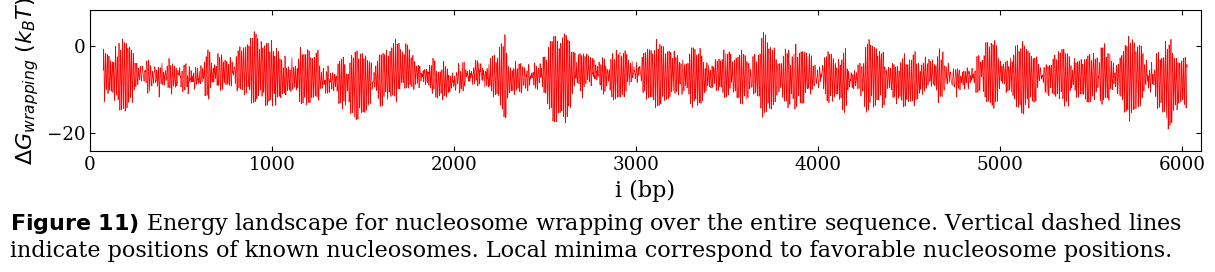

In [19]:
energy = calc_energy_landscape(seq, weight, octamer=True, show=True)

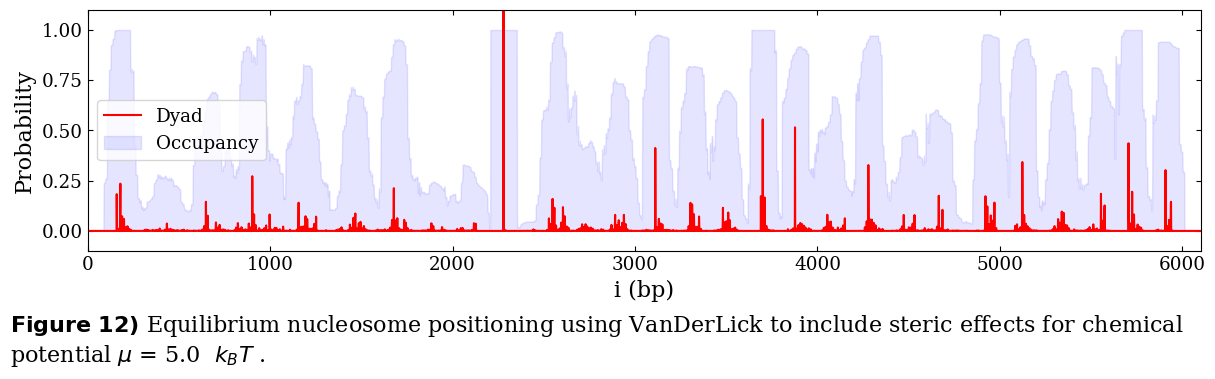

In [20]:
occupancy = compute_vanderlick(energy, mu=0.0, show=True)

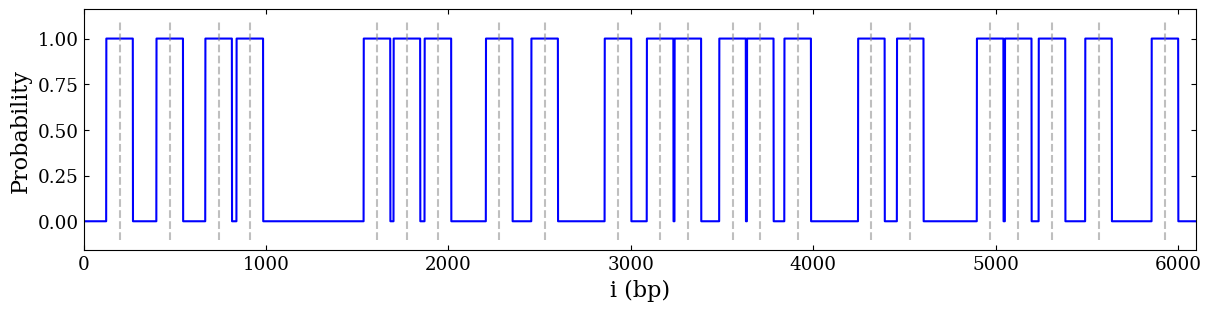

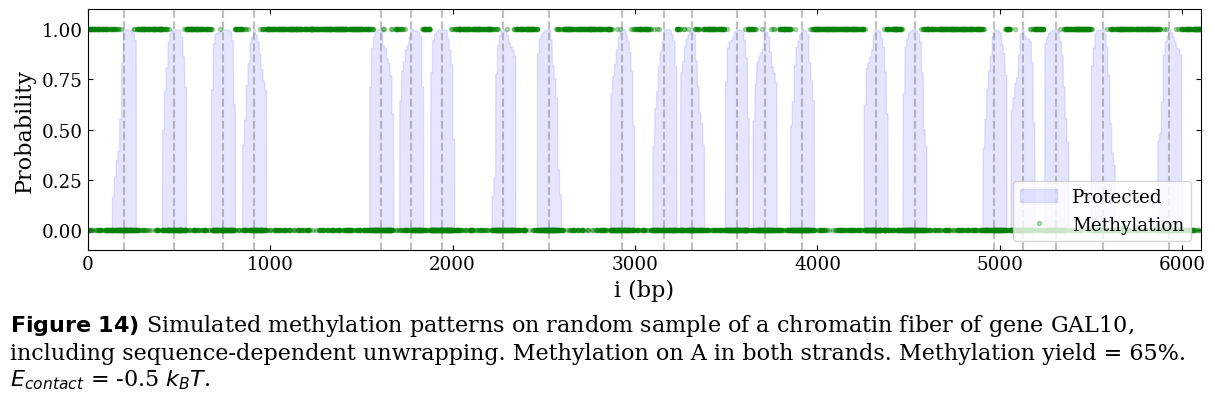

In [21]:
fiber = sample_fiber_configuration(occupancy.dyads, show=True)
caption = f"Simulated methylation patterns on random sample of a chromatin fiber of gene {c['gene_name']}, including sequence-dependent unwrapping. "
modified_fiber = calc_methylation(
    seq,
    fiber.dyads,
    e_contact=-0.5,
    efficiency=0.65,
    motifs=["A"],
    strand="both",
    show=caption,
)

100%|██████████| 200/200 [00:01<00:00, 176.30it/s]


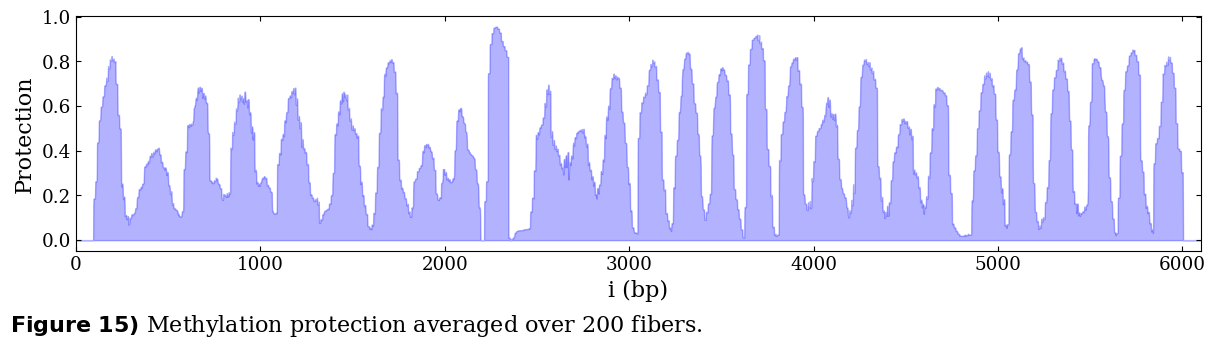

In [22]:
average_protection = np.zeros(len(seq))
n = 200
for _ in tqdm(range(n)):
    fiber = sample_fiber_configuration(occupancy.dyads, show=False)
    average_protection += calc_methylation(
        seq, fiber.dyads, e_contact=-0.5, efficiency=0.65, motifs=["A"], strand="both"
    ).protected
average_protection /= n

plot.new(fig_size=FIGSIZE)
plt.fill_between(
    np.arange(len(average_protection)), average_protection, color="blue", alpha=0.3
)
plt.xlim(0, len(seq))
plt.xlabel("i (bp)")
plt.ylabel("Protection")
# plt.legend()
plot.caption(f"Methylation protection averaged over {n} fibers.", filename=FILEOUT)